In [ ]:
#| default_exp dataloaders
#| default_cls_lvl 3

In [ ]:
#| include: false
%matplotlib widget
from fastai.callback.progress import *
from fastai.callback.tracker import *
from fastai.callback.schedule import *

In [ ]:
#| export
from tsfast.core import *
from tsfast.models.core import *
from tsfast.learner import *
from fastai.basics import *

import math

## Custom Dataloaders
> Pytorch Modules for Training Models for sequential data

The tbptt dataloader needs to split the minibatches that are created in several smaller minibatches that will be returned sequentially before the next minibatch may be created.

In [ ]:
#| export
from torch.utils.data.dataloader import _MultiProcessingDataLoaderIter,_SingleProcessDataLoaderIter,_DatasetKind
_loaders = (_MultiProcessingDataLoaderIter,_SingleProcessDataLoaderIter)

@delegates()
class TbpttDl(TfmdDL):

    def __init__(self, dataset, sub_seq_len=None, seq_len = None ,shuffle=True,num_workers=2, **kwargs):
#         assert sub_seq_len is not None
        store_attr('sub_seq_len,seq_len')
        self.rnn_reset = False
        super().__init__(dataset=dataset, shuffle=shuffle, num_workers=num_workers, **kwargs)
        
    @property
    def n_sub_seq(self):
        if self.sub_seq_len is None: return 1
        if self.seq_len is None: self.seq_len = self.do_item(0)[0].shape[0]
        return math.ceil(self.seq_len / self.sub_seq_len)
        
    def __len__(self):
        return super().__len__() * self.n_sub_seq
    
    def _next_worker(self,w_id):
        w_id += 1
        if w_id > self.fake_l.num_workers-1: w_id = 0
        return w_id

    def sample(self):
        #replaced new fastai sample formulation that store __idxs in main process
        return (b for i,b in enumerate(self.__idxs) if i//(self.bs or 1)%self.num_workers==self.offs)
#         return (b for i,b in enumerate(self.get_idxs()) if i//(self.bs or 1)%self.num_workers==self.offs)
            
    def __iter__(self):
        '''iterator that handles multiprocessing by caching samples that are generated out of order'''
        self.randomize()
        self.before_iter()
        self.__idxs=self.get_idxs() # called in context of main process (not workers/subprocesses)
        
        n_buffer = self.fake_l.num_workers*self.n_sub_seq
        queue = {n:[] for n in range(self.fake_l.num_workers)} 
        current_worker = None
        idx = 0
        for loaded_b,w_id in _loaders[self.fake_l.num_workers==0](self.fake_l):

            if w_id is None:
                self.rnn_reset=True
                b= loaded_b
                self.rnn_reset = (idx % self.n_sub_seq) == 0
                yield self.after_batch(b if self.device is None else to_device(b, self.device))
                idx += 1 #idx increments after every yield, not every loop
            else:
                if current_worker is None:
                    current_worker = w_id
                
                #retrieve queued elements from worker
                while len(queue[current_worker]) > 0:
                    b = queue[current_worker].pop(0)
                    self.rnn_reset = (idx % self.n_sub_seq) == 0
                    yield self.after_batch(b if self.device is None else to_device(b, self.device))
                    idx += 1
                    if (idx % self.n_sub_seq) == 0:
                        current_worker = self._next_worker(current_worker) #next worker, stay in loop for the queue
                        
                
                #retrieve fresh elements from worker
                if w_id != current_worker: #not active worker
                    queue[w_id] += [loaded_b]
                    continue
                else:#active worker
                    b = loaded_b
                    self.rnn_reset = (idx % self.n_sub_seq) == 0
                    yield self.after_batch(b if self.device is None else to_device(b, self.device))
                    idx += 1 #idx increments after every yield, not every loop
                    if (idx % self.n_sub_seq) == 0:
                        current_worker = self._next_worker(current_worker)
                
        self.after_iter()
        if hasattr(self, 'it'): del(self.it)
    
    def create_batches(self, samps):
        yield from self._tbptt_generator(super().create_batches(samps))
        
    def _tbptt_generator(self,batch_iter):
        '''generator function that splits batches in smaller windows, yields mini_batch and worker id'''
        for b in batch_iter:
            for i in range(self.n_sub_seq):
                #it is importan to retain the tuple type, or future transforms may now work
                if self.sub_seq_len is None:
                    trunc_b = b
                else:
                    trunc_b = tuple([retain_type(x[:,i*self.sub_seq_len:(i+1)*self.sub_seq_len],x) for x in b])
                yield trunc_b, (None if torch.utils.data.get_worker_info() is None else torch.utils.data.get_worker_info().id)
        

In [ ]:
from nbdev.config import get_config
project_root = get_config().config_file.parent
f_path = project_root / 'test_data/WienerHammerstein'

In [ ]:
tfm_lst = [DfHDFCreateWindows(win_sz=1000+1,stp_sz=1000,clm='u')]
seq = DataBlock(blocks=(SequenceBlock.from_hdf(['u','y'],TensorSequencesInput,clm_shift=[-1,-1]),
                        SequenceBlock.from_hdf(['y'],TensorSequencesOutput,clm_shift=[1])),
                 get_items=CreateDict(tfm_lst),
                 splitter=ApplyToDict(ParentSplitter()))
db = seq.dataloaders(get_hdf_files(f_path),dl_type=TbpttDl,sub_seq_len=100,num_workers=6)

In [ ]:
l = [array(x[-1][0,:,0].cpu()) for x in db.train]

[<matplotlib.lines.Line2D>]

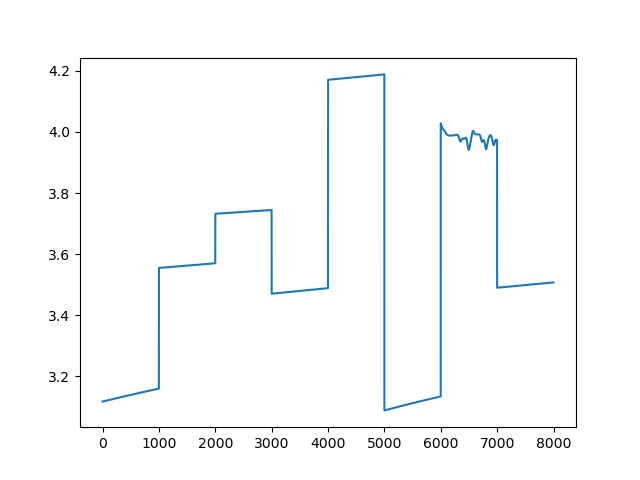

In [ ]:
plt.figure()
plt.plot(np.concatenate(l))

num_workers can be > 1 with the new synchronization procedure

## TBPTT_Reset_Callback
The stateful model needs to reset its hidden state, when a new sequence begins. The callback reads the reset flag and acts accordingly.

In [ ]:
#| export
def reset_model_state(model):
    for m in model.modules():
        if hasattr(m,'reset_state'): m.reset_state()

In [ ]:
#| export
class TbpttResetCB(Callback):
    "`Callback` resets the rnn model with every new sequence for tbptt, calls `reset_state` in every module of the model"
        
    def before_batch(self):
        dl = self.learn.dls.train if self.training else self.learn.dls.valid
#         if not self.training: import pdb; pdb.set_trace()
        if (hasattr(dl,'rnn_reset') and dl.rnn_reset) or not hasattr(dl,'rnn_reset'):
            reset_model_state(self.learn.model)
        
    def after_fit(self): 
        reset_model_state(self.learn.model)

## Example

In [ ]:
lrn = RNNLearner(db,num_layers=1,rnn_type='gru',stateful=False,metrics=[SkipNLoss(fun_rmse,1),fun_rmse])
lrn.add_cb(TbpttResetCB())

<fastai.learner.Learner>

In [ ]:
lrn.fit_one_cycle(1,lr_max=3e-2)

epoch,train_loss,valid_loss,fun_rmse,fun_rmse,time
0,1.505455,0.225024,0.348194,0.473599,00:03


In [ ]:
db.train.sub_seq_len = 10

In [ ]:
lrn.fit_one_cycle(1,lr_max=3e-2)

epoch,train_loss,valid_loss,fun_rmse,fun_rmse,time
0,0.000064,0.000101,0.007965,0.008134,00:07


# Weighted Sampling Dataloader

A weighted sampling dataloader for nonuniforly distributed data. A factory method receives the base Dataloader class and returns the inherited weighted sampling dataloader class

In [ ]:
#| export
def WeightedDL_Factory(cls):
    '''
    Weighted Dataloader that provides control over sampling probabilities.
    wgts: probability array with probability for every item
            gets extracted from the pandas 'p_sample' column if given. 
            Otherwise uniform sampling will be enabled
        
    '''
    assert issubclass(cls, TfmdDL)
    
    class WeightedDL(cls):
        def __init__(self, dataset, wgts=None, **kwargs):
#             import pdb;pdb.set_trace()
            self.wgts = None
            #self.items need to be assigned, but super.init needs wgts allready assigned
            super().__init__(dataset=dataset, **kwargs) 
            if wgts is None:
                if (isinstance(self.items,pd.DataFrame) and
                    len(self.items) > 0 and 
                    'p_sample' in self.items):
                    self.wgts = self.items.p_sample.to_numpy()
                    self.wgts = self.wgts/self.wgts.sum()
                elif (isinstance(self.items,Iterable) and
                    len(self.items) > 0 and 
                    hasattr(self.items[0],'keys') and 
                    'p_sample' in self.items[0].keys()):
                    self.wgts = np.array([x['p_sample'] for x in self.items])
                    self.wgts = self.wgts/self.wgts.sum()
                else:
                    print('No wgts provided for WeightedDL. Was that intentional?')
            else:
                self.wgts = wgts/np.sum(wgts)

        def get_idxs(self):
            if self.n==0: return []
            if not self.shuffle or self.wgts is None: return super().get_idxs()
            #calculate number of elements with length of the dataset, for batch truncation
            idxs = list(np.random.choice(self.n, size=len(self)*self.bs, p=self.wgts))
            return idxs
    return WeightedDL

In [ ]:
dl = WeightedDL_Factory(TfmdDL)([1,2]*5,bs=10,wgts=[2,1]*5)

In [ ]:
lrn = RNNLearner(db,num_layers=1,rnn_type='gru',stateful=False,metrics=[SkipNLoss(fun_rmse,1),fun_rmse])
lrn.fit_one_cycle(1,lr_max=3e-2)

epoch,train_loss,valid_loss,fun_rmse,fun_rmse,time
0,0.000429,0.019677,0.140848,0.140151,00:07


In [ ]:
dl.wgts

array([0.13333333, 0.06666667, 0.13333333, 0.06666667, 0.13333333,
       0.06666667, 0.13333333, 0.06666667, 0.13333333, 0.06666667])

In [ ]:
dl.one_batch()

tensor([1, 2, 1, 2, 1, 2, 1, 2, 1, 2])

## ItemLst Transform for weight calculation

In [ ]:
#| export
def uniform_p_of_category(cat_name):  
    '''Scales sampling weights for an even distribution between every category'''
    def _inner(df):
        if 'p_sample' in df:
            df_targ = df.drop('p_sample',axis='columns')
        else:
            df_targ = df
            
        counts = df_targ[cat_name].value_counts()
        sample_prob =  1/counts
        sample_prob.name = 'p_sample'
        df_res = df_targ.merge(sample_prob,left_on=cat_name,right_index=True)
        
        if 'p_sample' in df: 
            df_res.p_sample = df_res.p_sample* df.p_sample.values
            
        df_res.p_sample /= df_res.p_sample.sum()
            
        return df_res
    
    return _inner

In [ ]:
#| export
def uniform_p_of_float(var_name,bins = 10):
    '''Scales sampling weights for an even distribution of the continous variable by creating equi sized bins'''
    def _inner(df):
        if 'p_sample' in df:
            df_targ = df.drop('p_sample',axis='columns')
        else:
            df_targ = df
            
        df_targ['bins'] = pd.cut(df_targ[var_name], bins)
        counts = df_targ['bins'].value_counts()
        sample_prob =  1/counts
        sample_prob.name = 'p_sample'
        df_res = df_targ.merge(sample_prob,left_on='bins',right_index=True)
        df_res.drop(['bins'],axis='columns',inplace=True)
        
        if 'p_sample' in df: 
            df_res.p_sample = df_res.p_sample* df.p_sample.values
            
        df_res.p_sample /= df_res.p_sample.sum()
        
        return df_res

    return _inner

In [ ]:
#| export
def uniform_p_of_float_with_gaps(var_name,bins = 100):
    '''Scales sampling weights for an even distribution of the continous variable by creating equi sized bins'''
    def _inner(df):
        if 'p_sample' in df:
            df_targ = df.drop('p_sample',axis='columns')
        else:
            df_targ = df
            
        l = df_targ[var_name].max()-df_targ[var_name].min() #value range
        df_targ['bins'] = pd.qcut(df_targ[var_name],bins,duplicates='drop') #bins with rougly the same size
        df_targ['p_sample'] =  df_targ['bins'].apply(lambda x: x.length).astype('f8')/l #sample_prob by bin width
        sample_prob =  1/df_targ['bins'].value_counts() #correct uneven bin distribution
        sample_prob.name = 'p_sample_correction'
        df_res = df_targ.merge(sample_prob,left_on='bins',right_index=True)
        
        df_res.p_sample *= df_res.p_sample_correction
        df_res.drop(['bins','p_sample_correction'],axis='columns',inplace=True)

        if 'p_sample' in df: 
            df_res.p_sample = df_res.p_sample* df.p_sample.values
            
        df_res.p_sample /= df_res.p_sample.sum()
        
        return df_res

    return _inner

In [ ]:
def train_valid(df):   
    ''' test function that extracts valid and train from the path string'''
    df['train'] = df.path.astype(str).str.contains('train',regex=False)
    return df

In [ ]:
# %%time
tfm_lst = [train_valid, DfHDFCreateWindows(win_sz=1000+1,stp_sz=1000,clm='u') ,uniform_p_of_category('train'),uniform_p_of_float('l_slc'),uniform_p_of_float_with_gaps('r_slc')]
apply_df_tfms(get_hdf_files(f_path),tfm_lst) 

,path,train,l_slc,r_slc,p_sample
0,test_data/battery/train/Sim_RealisticCycle1.hdf5,True,0,1001,0.000619
0,test_data/battery/train/Sim_RealisticCycle1.hdf5,True,1000,2001,0.000619
0,test_data/battery/train/Sim_RealisticCycle1.hdf5,True,2000,3001,0.000619
0,test_data/battery/train/Sim_RealisticCycle1.hdf5,True,3000,4001,0.000929
0,test_data/battery/train/Sim_RealisticCycle1.hdf5,True,4000,5001,0.000929
...,...,...,...,...,...
2,test_data/battery/valid/Sim_RealisticCycle3.hdf5,False,260000,261001,0.001858
2,test_data/battery/valid/Sim_RealisticCycle3.hdf5,False,261000,262001,0.001858
2,test_data/battery/valid/Sim_RealisticCycle3.hdf5,False,262000,263001,0.001858
2,test_data/battery/valid/Sim_RealisticCycle3.hdf5,False,263000,264001,0.001858


In [ ]:
seq = DataBlock(blocks=(SequenceBlock.from_hdf(['u','y'],TensorSequencesInput,clm_shift=[-1,-1]),
                        SequenceBlock.from_hdf(['y'],TensorSequencesOutput,clm_shift=[1])),
                 get_items=CreateDict(tfm_lst),
                 splitter=ApplyToDict(ParentSplitter()))
# db = seq.dataloaders(get_hdf_files('test_data/battery'),dl_type=TbpttDl,sub_seq_len=200)
db = seq.dataloaders(get_hdf_files(f_path),dl_type=WeightedDL_Factory(TbpttDl),sub_seq_len=500)

In [ ]:
db.train.wgts.shape

(530,)

In [ ]:
db.train.wgts[:5],db.valid.wgts[:5]

(array([0.00123895, 0.00123895, 0.00123895, 0.00185842, 0.00185842]),
 array([0.00247789, 0.00247789, 0.00247789, 0.00371683, 0.00371683]))

In [ ]:
lrn = RNNLearner(db,num_layers=1,rnn_type='gru',stateful=False,metrics=[SkipNLoss(fun_rmse,1),fun_rmse])
lrn.add_cb(TbpttResetCB())
lrn.fit_one_cycle(1,lr_max=3e-2)

epoch,train_loss,valid_loss,fun_rmse,fun_rmse,time
0,5.394642,0.385504,0.578141,0.595691,00:01


## Importance Sampling Callback

In [ ]:
# #| export
# class ImportanceSampling(Callback):
#     #modify the dataloader weights to sample items with higher loss more often
#     def __init__(self, filter_criterion=nn.HuberLoss(reduction='none')):
#         self.filter_criterion = filter_criterion
#         self.loss_list = None #store loss of each item in the dataloader

#     def begin_fit(self):
#         #empty the loss list at the beginning of each fit
#         self.loss_list = None

#     def after_pred(self):
#         # store loss of each item in the batch
#         if not self.training: return
#         losses = self.filter_criterion(self.learn.pred, *self.learn.yb)
#         if losses.ndim >= 2: losses = losses.mean(tuple(range(1,losses.ndim)))  # If loss is multi-dimensional, take the mean over all but the first dimension
#         #get the indices of each item in the batch from the dataloader
#         # import pdb; pdb.set_trace()

#         #if the loss_list is empty, initialize it with dataloader wgts
#         if self.loss_list is None:
#             self.loss_list = self.learn.dls.train.wgts.clone()
#             #scale the loss_list mean to the mean loss of the batch
#             self.loss_list *= self.loss_list.numel()/losses.mean()

#         #store the loss of each item in the loss_list
        
#     def after_epoch(self):
#         #modify the dataloader weights to sample items with higher loss more often
#         if not self.training: return
#         self.learn.dls.train.wgts = self.loss_list
#         self.learn.dls.train.wgts /= self.learn.dls.train.wgts.sum()

    

        

In [ ]:
# lrn = RNNLearner(db,num_layers=1,stateful=False,metrics=[SkipNLoss(fun_rmse,1),fun_rmse],cbs=ImportanceSampling())
# lrn.fit(1)

In [ ]:
# tfm_lst = [train_valid, DfHDFCreateWindows(win_sz=500+1,stp_sz=500,clm='u')]
# seq = DataBlock(blocks=(SequenceBlock.from_hdf(['u','y'],TensorSequencesInput,clm_shift=[-1,-1]),
#                         SequenceBlock.from_hdf(['y'],TensorSequencesOutput,clm_shift=[1])),
#                  get_items=CreateDict(tfm_lst),
#                  splitter=ApplyToDict(ParentSplitter()))
# # db = seq.dataloaders(get_hdf_files('test_data/battery'),dl_type=TbpttDl,sub_seq_len=200)
# db = seq.dataloaders(get_hdf_files('test_data/battery'),dl_type=WeightedDL_Factory(TfmdDL))

# RNNLearner(db,num_layers=1,stateful=False,metrics=[SkipNLoss(fun_rmse,1),fun_rmse],cbs=ImportanceSampling()).fit(1)

# Mini Batch Limiter Dataloader

A weighted sampling dataloader for nonuniforly distributed data. A factory method receives the base Dataloader class and returns the inherited weighted sampling dataloader class

In [ ]:
#| export
def BatchLimit_Factory(cls):
    '''
    Batch limited Dataloader that provides an upper limit for the number of mini batches per epoch
    max_batches: upper limit for minibatch count per epoch
        
    '''
    assert issubclass(cls, TfmdDL)
    
    class BatchLimitDL(cls):
        def __init__(self, dataset, max_batches=None, **kwargs):
            self.max_batches = max_batches
            # kwargs['n'] = max_batches*kwargs['bs'] n has to remain the full size, in order to create all indices if shuffled
            super().__init__(dataset=dataset, **kwargs)

        def __len__(self):
            l = super().__len__() 
            if self.max_batches is not None: l = min(l,self.max_batches)
            return l

        def __iter__(self):
            if self.max_batches is None: 
                yield from super().__iter__()
            else:
                for idx,b in enumerate(super().__iter__()):
                    if idx >= self.max_batches: break
                    yield b
                    
        #shuffle function that is called in super().get_idxs, truncated for faster execution
        def shuffle_fn(self, idxs): return self.rng.sample(idxs, min(len(self)*self.bs,len(idxs)))
                    
        #get_idxs is truncated for the non-shuffling case, otherwise shuffle_fn is already truncated
        def get_idxs(self):
            return super().get_idxs()[:len(self)*self.bs]

    return BatchLimitDL

In [ ]:
dl = BatchLimit_Factory(TfmdDL)([1,2]*5,bs=2,max_batches=3,shuffle=False)

In [ ]:
len(dl)

3

In [ ]:
dl.get_idxs()

[0, 1, 2, 3, 4, 5]

In [ ]:
BatchLimit_Factory(TfmdDL)([1,2]*5,bs=2,max_batches=3,shuffle=True).get_idxs()

[6, 0, 7, 2, 5, 4]

In [ ]:
[x for x in dl]

[tensor([1, 2]), tensor([1, 2]), tensor([1, 2])]

In [ ]:
len(dl)

3

In [ ]:
#| include: false
import nbdev; nbdev.nbdev_export()